In [1]:
import os
%matplotlib inline
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
import imageio
import cv2

import datetime as dt
import pandas as pd
import random
import radon_monitor
rm = radon_monitor.Radon_Monitor()

In [2]:
from custom_image_tools import browse_files, cutout, send_back_to_training


# Purpose
1) develop a program to read raw images and outputs DataFrame of historical data and visualizations

## Table of Contents <a name = 'toc'></a>
1. Pull Historical Data
2. Add New Raw Images
3. Random Sampling/Browsing
4. Reading Images
5. View Model Disagreement
6. Visualizations
7. Save Data

## Pull Historical Data

In [3]:
data_fp = '/Volumes/wellington/projects/radon_monitor/data/'
hourly_test_fp = data_fp + 'hourly_tests/'
og_images_fp = data_fp + 'og_images/'

In [4]:
img_df = pd.read_csv('./results.csv')
img_df['img_date'] = pd.to_datetime(img_df['img_date'])
img_df = img_df.dropna(subset = ['short_term_span'])
img_df['month'] = img_df['img_date'].dt.month
img_df['day'] = img_df['img_date'].dt.day
img_df['year'] = img_df['img_date'].dt.year
print(len(img_df))
img_df.head()


753


,Unnamed: 0,img_date,img_path,img_name,short_term_span,short_term,long_term,nn_short_term_span,nn_short_term,nn_long_term,models agree,hour,month,day,year
0,0.0,2022-01-06 20:25:00,/Volumes/wellington/projects/radon_monitor/dat...,tests_01-06-2022_2025.png,7.0,3.75,3.77,7.0,3.75,3.75,False,20,1,6,2022
1,1.0,2022-01-06 19:24:00,/Volumes/wellington/projects/radon_monitor/dat...,tests_01-06-2022_1924.png,1.0,1.41,3.77,1.0,1.41,3.75,False,19,1,6,2022
2,2.0,2022-01-06 18:23:00,/Volumes/wellington/projects/radon_monitor/dat...,tests_01-06-2022_1823.png,7.0,3.77,3.77,7.0,3.75,3.75,False,18,1,6,2022
3,3.0,2022-01-06 17:22:00,/Volumes/wellington/projects/radon_monitor/dat...,tests_01-06-2022_1722.png,1.0,1.70,3.77,1.0,1.78,3.75,False,17,1,6,2022
4,4.0,2022-01-06 16:22:00,/Volumes/wellington/projects/radon_monitor/dat...,tests_01-06-2022_1622.png,1.0,1.41,3.77,1.0,1.41,3.75,False,16,1,6,2022


## Add New Raw Images

In [68]:
# Intalize a fresh data set
#img_df = pd.DataFrame(columns = ['img_date','img_path','img_name'])

In [69]:
# intilize dataframe for images not analyzied yet
new_img = pd.DataFrame()
for i, f in enumerate(os.scandir(hourly_test_fp)):
    if not f.name.startswith('test'):continue
    if not f.name in list(img_df['img_name']):
    
        new_img.loc[i,'img_date'] = rm._date_extractor(f.name)
        new_img.loc[i,'img_path'] = hourly_test_fp+f.name 
        new_img.loc[i,'img_name'] = f.name

new_img = new_img.sort_values(by='img_date',ascending = False)\
             .reset_index(drop = True)
print(new_img.shape)
new_img.head()

(808, 3)


,img_date,img_path,img_name
0,2022-01-09 10:19:00,/Volumes/wellington/projects/radon_monitor/dat...,tests_01-09-2022_1019.png
1,2022-01-09 09:18:00,/Volumes/wellington/projects/radon_monitor/dat...,tests_01-09-2022_0918.png
2,2022-01-09 08:17:00,/Volumes/wellington/projects/radon_monitor/dat...,tests_01-09-2022_0817.png
3,2022-01-09 07:16:00,/Volumes/wellington/projects/radon_monitor/dat...,tests_01-09-2022_0716.png
4,2022-01-09 06:15:00,/Volumes/wellington/projects/radon_monitor/dat...,tests_01-09-2022_0615.png


In [6]:
def get_coordinates(fp,position):
    position_coord_df = rm.coordinates(fp)
    position_mask = position_coord_df['position'] == position
    return position_coord_df[position_mask].coordinates.values[0]
    
#get_coordinates(img_df.loc[0,'img_path'],'short_term_0')

In [7]:
def read_image(image_fp_,model,returns_array = True,display_img = False,normalize = False):
    if display_img: browse_files(image_fp_)
    def read_cutout(cut):
        the_image = cutout(cut,image_fp_,return_data=True,show = False)
        the_image = cv2.resize(the_image,(28,28)).flatten()
        if normalize:
            the_image = the_image
        pred = model.predict(the_image.reshape((1,-1))/255)[0]
        if returns_array:return pred.argmax()
        else: return pred

    short_term_days_value = read_cutout(get_coordinates(image_fp_,'short_term_span'))
    
    short_term_0_value = read_cutout(get_coordinates(image_fp_,'short_term_0'))
    short_term_1_value = read_cutout(get_coordinates(image_fp_,'short_term_1'))
    short_term_2_value = read_cutout(get_coordinates(image_fp_,'short_term_2'))
    short_term_value = short_term_0_value + 0.1* short_term_1_value + 0.01 * short_term_2_value
    
    long_term_0_value = read_cutout(get_coordinates(image_fp_,'long_term_0'))
    long_term_1_value = read_cutout(get_coordinates(image_fp_,'long_term_1'))
    long_term_2_value = read_cutout(get_coordinates(image_fp_,'long_term_2'))
    long_term_value = long_term_0_value + 0.1 * long_term_1_value + 0.01*long_term_2_value
    
    values = {'days':int(short_term_days_value),
             'short_term':round(short_term_value,2),
             'long_term':round(long_term_value,2)}
    return values



## Random Sample Browsing

In [9]:
from joblib import dump, load
clf = load('logistic_regression.joblib') 
nn_model = load('nn_model.joblib')

log_reg values = {'days': 7, 'short_term': 3.71, 'long_term': 3.77}
Sequential NN values = {'days': 7, 'short_term': 3.51, 'long_term': 3.77}
Photo taken:  2022-01-09 10:19:00
CPU times: user 1.48 s, sys: 96.7 ms, total: 1.58 s
Wall time: 4.44 s


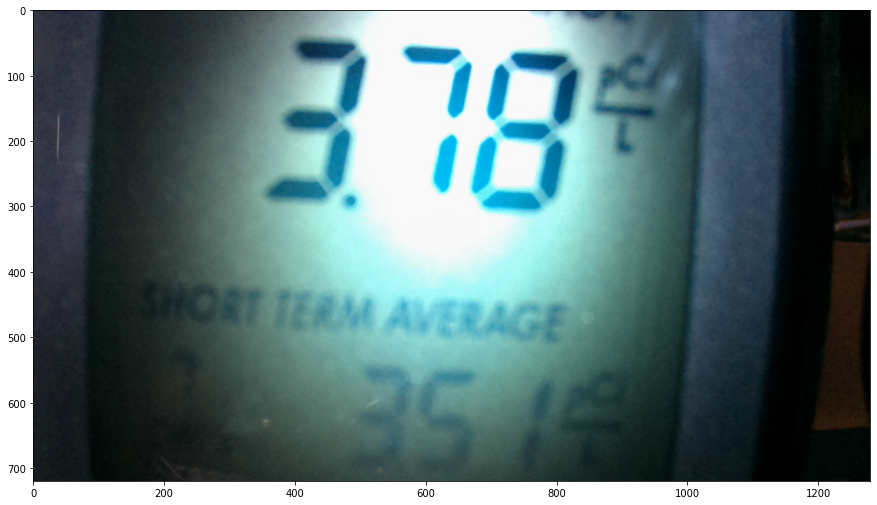

In [10]:
%%time
i = random.randint(0,len(new_img))
fp = new_img.loc[0,'img_path']
nn_values = read_image(fp,nn_model,display_img = False,normalize = True)
values = read_image(fp,clf,returns_array = False,display_img = True)
print('log_reg values = {}'.format(values))
print('Sequential NN values = {}'.format(nn_values))
print('Photo taken: ',dt.datetime.strptime(fp[-19:-4],"%m-%d-%Y_%H%M"))

## Reading the Images

In [18]:
from joblib import dump, load
clf = load('logistic_regression.joblib') 
nn_model = load('nn_model.joblib')

In [71]:
%%time
def read_files(df,fname = None,samples = None):
    '''reades files from dataframe.  Dataframe must have a img_path column'''
    import time
    for i, fp in enumerate(df['img_path']):
        i_time = time.time()
        try:
            log_results = read_image(fp,clf,returns_array = False)
            nn_results = read_image(fp,nn_model,normalize = True)
        except:pass
        df.loc[i,'short_term_span'] = log_results['days']
        df.loc[i,'short_term'] = log_results['short_term']
        df.loc[i,'long_term'] = log_results['long_term']
        df.loc[i,'nn_short_term_span'] = nn_results['days']
        df.loc[i,'nn_short_term'] = nn_results['short_term']
        df.loc[i,'nn_long_term'] = nn_results['long_term']
        if (df.loc[i,'short_term_span'] != df.loc[i,'nn_short_term_span']) or (df.loc[i,'short_term'] != df.loc[i,'nn_short_term'])or(df.loc[i,'long_term'] != df.loc[i,'nn_long_term']):
            df.loc[i,'models agree'] = False
        else: df.loc[i,'models agree'] = True
        if i in range(0,len(new_img),50):
            f_time = time.time()
            print('{} out of {} complete in {} seconds'.format(i,len(df),ftime-i_time))
            try:df.to_csv(fname)
            except:_ = input('Try closing results.csv')
        if not samples == None:
            if i>samples: break
    df['hour'] = df.img_date.dt.hour
    df['month'] = df.img_date.dt.month
    if not fname == None:
        try:df.to_csv(fname)
        except:_ = input('Try closing results.csv')

    return df
new_img = read_files(new_img)
new_img.head()  

0 out of 808 complete
50 out of 808 complete
100 out of 808 complete
150 out of 808 complete
200 out of 808 complete
250 out of 808 complete
300 out of 808 complete
350 out of 808 complete
400 out of 808 complete
450 out of 808 complete
500 out of 808 complete
550 out of 808 complete
600 out of 808 complete
650 out of 808 complete
700 out of 808 complete
750 out of 808 complete
800 out of 808 complete
CPU times: user 17min 5s, sys: 1min 10s, total: 18min 15s
Wall time: 23min 56s


,img_date,img_path,img_name,short_term_span,short_term,long_term,nn_short_term_span,nn_short_term,nn_long_term,models agree,hour,month
0,2022-01-09 10:19:00,/Volumes/wellington/projects/radon_monitor/dat...,tests_01-09-2022_1019.png,7.0,3.71,3.77,7.0,3.51,3.77,False,10,1
1,2022-01-09 09:18:00,/Volumes/wellington/projects/radon_monitor/dat...,tests_01-09-2022_0918.png,1.0,3.45,3.77,1.0,3.45,3.77,True,9,1
2,2022-01-09 08:17:00,/Volumes/wellington/projects/radon_monitor/dat...,tests_01-09-2022_0817.png,1.0,3.70,3.77,1.0,3.78,3.77,False,8,1
3,2022-01-09 07:16:00,/Volumes/wellington/projects/radon_monitor/dat...,tests_01-09-2022_0716.png,7.0,3.71,3.77,7.0,3.51,3.77,False,7,1
4,2022-01-09 06:15:00,/Volumes/wellington/projects/radon_monitor/dat...,tests_01-09-2022_0615.png,7.0,3.71,3.77,7.0,3.51,3.77,False,6,1


In [72]:
df = pd.concat([img_df,new_img])

## Reading a specific day


        --------------------------------------------
        Logistic Regression      | NN
        ---------------------------------------------
        short_term_span = 1.0    |short_term_span = 1.0
        long_term = 3.72         |long_term = 3.72
        short_term = 4.16        |short_term = 4.16

        


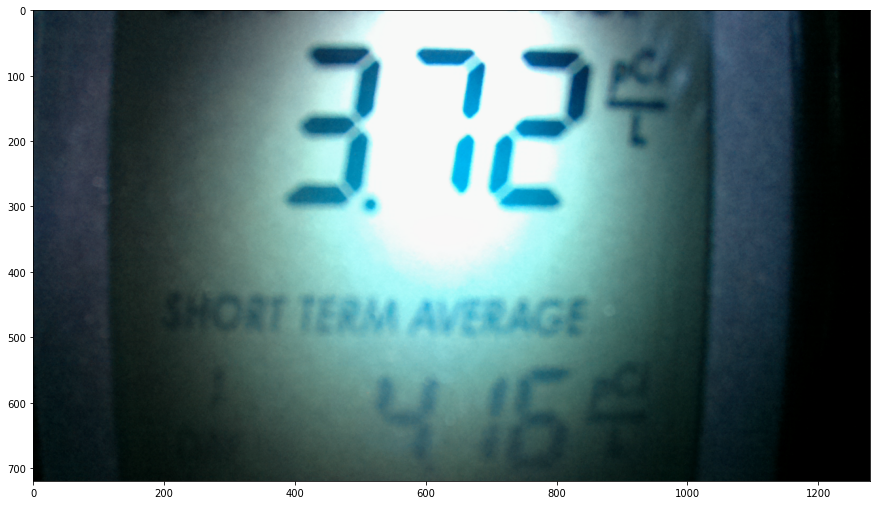

In [75]:
def read_specific_day(year = 2021,day = 22, month = 11,hour = 6):
    date = dt.date(year = year,day=day,month = month)
    hour_mask = df['hour'] == hour
    date_mask = df['img_date'].dt.date == date
    row = df[date_mask]
    if len(row) != 0:
        row = df[date_mask&hour_mask]
        if len(row) != 0:
            print('''
        --------------------------------------------
        Logistic Regression      | NN
        ---------------------------------------------
        short_term_span = {}    |short_term_span = {}
        long_term = {}         |long_term = {}
        short_term = {}        |short_term = {}

        '''.format(
            row.short_term_span.values[0], row.nn_short_term_span.values[0],
            row.long_term.values[0],row.nn_long_term.values[0],
            row.short_term.values[0],row.nn_short_term.values[0]))
            
            rm.browse_photos(row.img_path.values[0])
        else:
            print('Hour not found')
    else:
        print('Date not found')
    
    
read_specific_day(year = 2021,day = 22, month = 11,hour = 0)

log_reg values = {'days': 7, 'short_term': 3.7, 'long_term': 3.72}
Sequential NN values = {'days': 7, 'short_term': 3.7, 'long_term': 3.72}
Photo taken:  2021-11-22 10:23:00


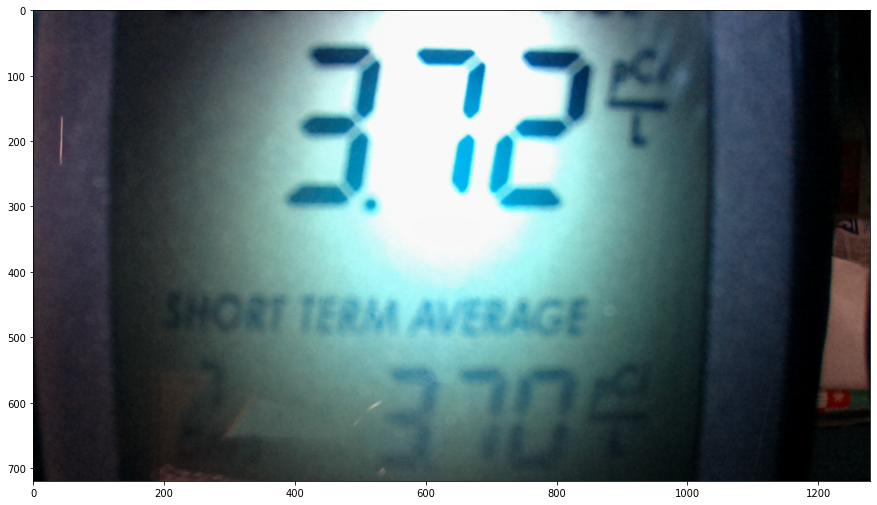

In [65]:
def model_read_day(df,year = 2021,day = 22, month = 11,hour = 6):
    date = dt.date(year = year,day=day,month = month)
    date_mask = df['img_date'].dt.date == date
    hour_mask = df['hour'] == hour
    row = df[date_mask]
    if len(row) != 0:
        row = df[date_mask&hour_mask]
        if len(row)!=0:
            fp = df[date_mask].img_path
            nn_values = read_image(fp,nn_model,display_img = False,normalize = True)
            values = read_image(fp,clf,returns_array = False,display_img = True)
            print('log_reg values = {}'.format(values))
            print('Sequential NN values = {}'.format(nn_values))
            print('Photo taken: ',dt.datetime.strptime(fp[-19:-4],"%m-%d-%Y_%H%M"))
        else: print('Hour not found')
    else:print('Date not found')
model_read_day(df,year = 2021,day = 22, month = 11,hour = 6)

## Assessing where the models disagree

Total model disagreements = 362 out of 808
        Example = 0 Date = 09-Jan-2022
        --------------------------------------------
        Logistic Regression      | NN
        ---------------------------------------------
        short_term_span = 7.0    |short_term_span = 7.0
        long_term = 3.77         |long_term = 3.77
        short_term = 3.71        |short_term = 3.51

        


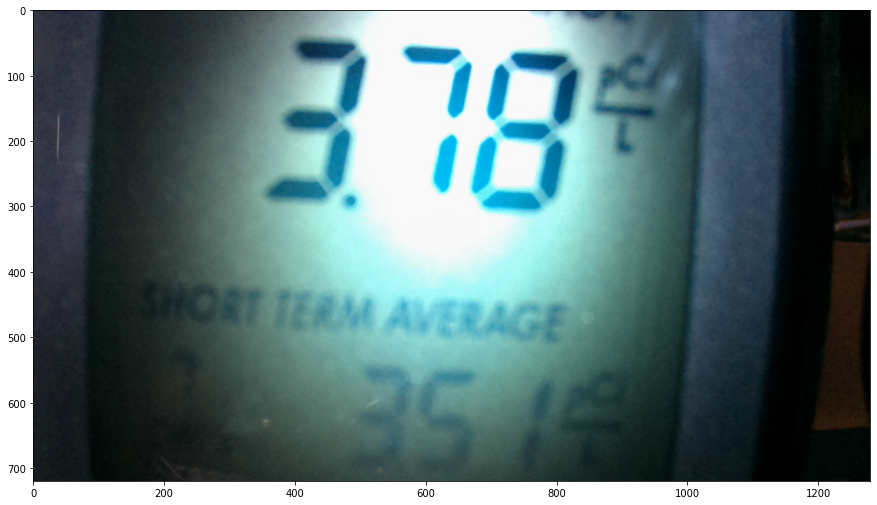

Continue to next example? y/n n


In [76]:
def assess_model_disagreements(df):
    disagree_df = df[df['models agree']==False].reset_index(drop = True)
    i = 0
    while True:
        row = disagree_df.loc[i]
        print('''Total model disagreements = {} out of {}
        Example = {} Date = {}
        --------------------------------------------
        Logistic Regression      | NN
        ---------------------------------------------
        short_term_span = {}    |short_term_span = {}
        long_term = {}         |long_term = {}
        short_term = {}        |short_term = {}

        '''.format(len(disagree_df),sum(~df['short_term_span'].isna()),i,row.img_date.strftime('%d-%b-%Y'),
            row.short_term_span, row.nn_short_term_span,
            row.long_term,row.nn_long_term,
            row.short_term,row.nn_short_term))
        fp = disagree_df.loc[i,'img_path']
        rm.browse_photos(fp)
        ans = input("Continue to next example? y/n")
        if ans == 'y':
            i+=1
            continue
        else: break
    
assess_model_disagreements(df)


## Visualizations

In [77]:
df = df.sort_values(by = 'img_date')

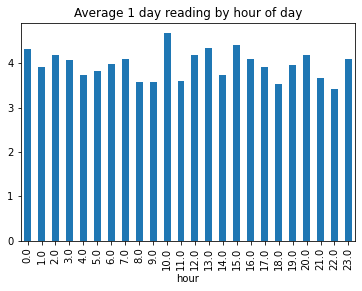

In [78]:
df[df['nn_short_term_span']==1].groupby('hour')['nn_short_term'].mean().plot(kind = 'bar')
plt.title('Average 1 day reading by hour of day')
plt.show()


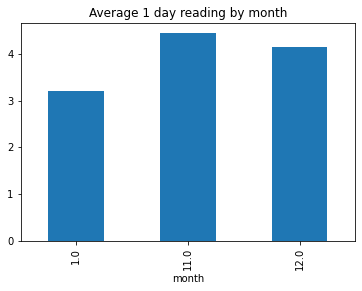

In [79]:
df[df['nn_short_term_span']==1].groupby('month')['nn_short_term'].mean().plot(kind = 'bar')
plt.title('Average 1 day reading by month')
plt.show()

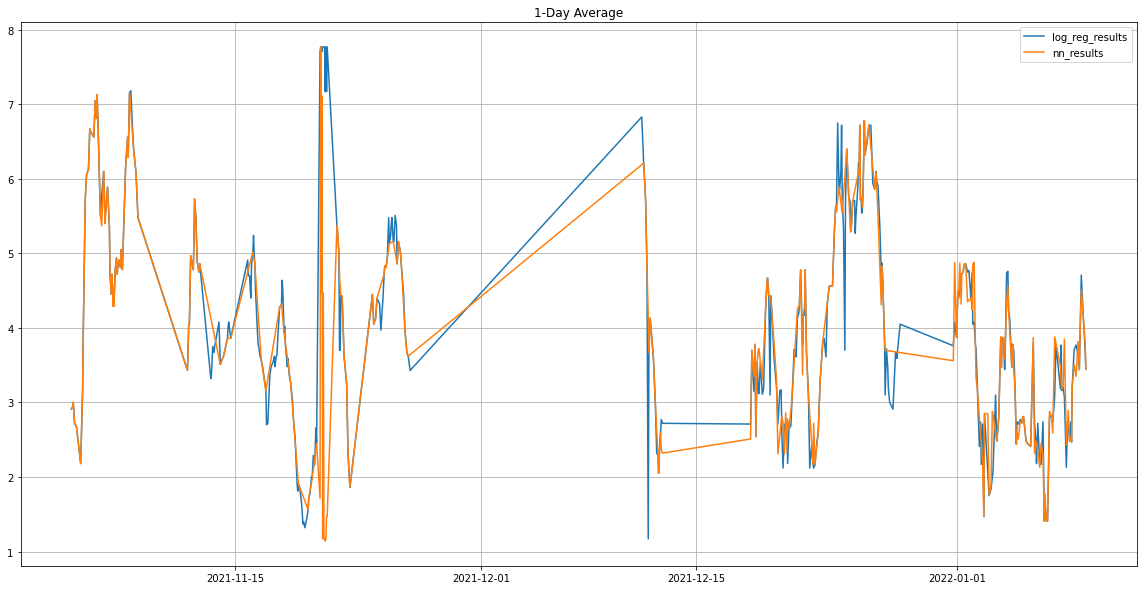

In [80]:
st_time_span = 1
x = df.img_date[df['short_term_span'] == st_time_span]
x2 = df.img_date[df['nn_short_term_span'] == st_time_span]
y = df.short_term[df['short_term_span']==st_time_span]
y2 = df.nn_short_term[df['nn_short_term_span']==st_time_span]
plt.figure(figsize = (20,10))
plt.title('1-Day Average')
plt.plot(x,y,label = 'log_reg_results')
plt.plot(x2,y2,label='nn_results')
plt.grid(True)
plt.legend()
plt.show()

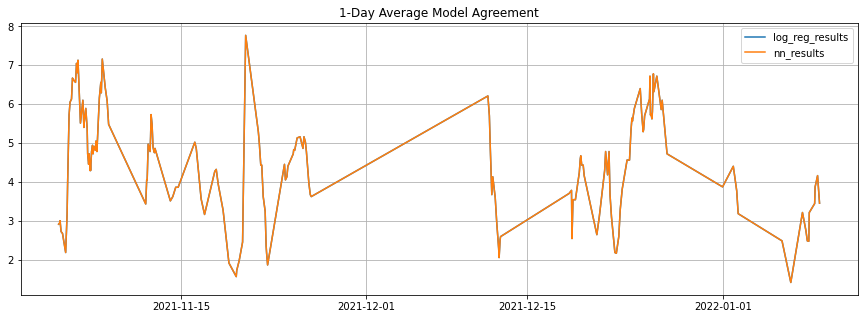

In [82]:
# removing disagreeing data
st_time_span = 1
models_agree_df = df[df['models agree']==True].reset_index(drop = True)
models_agree_df=models_agree_df.sort_values(by='img_date')
x = models_agree_df.img_date[models_agree_df['short_term_span'] == st_time_span]
x2 = models_agree_df.img_date[models_agree_df['nn_short_term_span'] == st_time_span]
y = models_agree_df.short_term[models_agree_df['short_term_span']==st_time_span]
y2 = models_agree_df.nn_short_term[models_agree_df['nn_short_term_span']==st_time_span]
plt.figure(figsize = (15,5))
plt.title('1-Day Average Model Agreement')
plt.plot(x,y,label = 'log_reg_results')
plt.plot(x2,y2,label='nn_results')
plt.grid(True)
plt.legend()
plt.show()


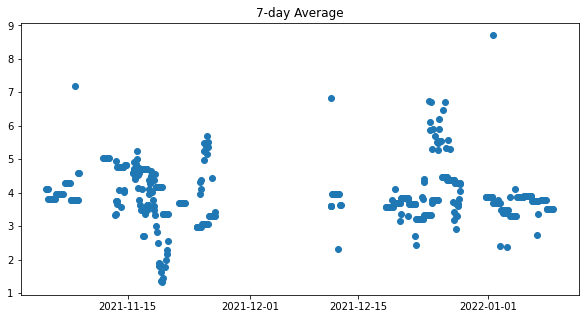

In [83]:
st_time_span = 7
x = df.img_date[df['nn_short_term_span'] == st_time_span]
y = df.nn_short_term[df['nn_short_term_span']==st_time_span]
plt.figure(figsize = (10,5))
plt.title('7-day Average')
plt.scatter(x,y)
plt.show()

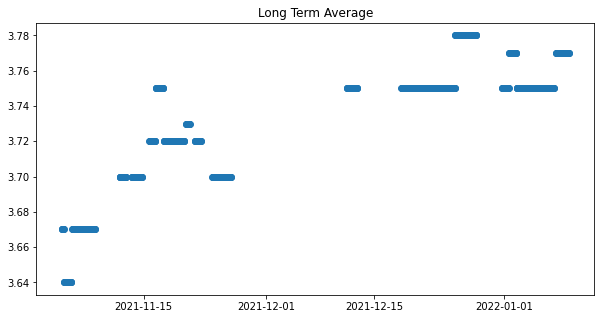

In [84]:

x = df.img_date
y = df.nn_long_term
plt.figure(figsize = (10,5))
plt.title('Long Term Average')
plt.scatter(x,y)
plt.show()

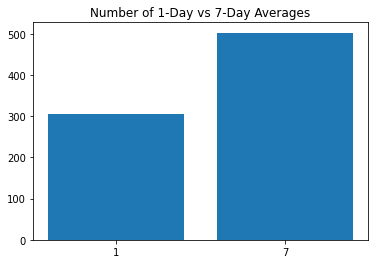

In [85]:
plt.title('Number of 1-Day vs 7-Day Averages')
plt.bar(x= ["1","7"],height = [(df['nn_short_term_span'] == 1).sum(),(df['nn_short_term_span'] == 7).sum()])
plt.show()

## Save

In [86]:
df.to_csv('./results.csv',index = False)